# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [2]:
#print("x_train : \n", x_train)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 100
Image dimensions: (32, 32, 3)


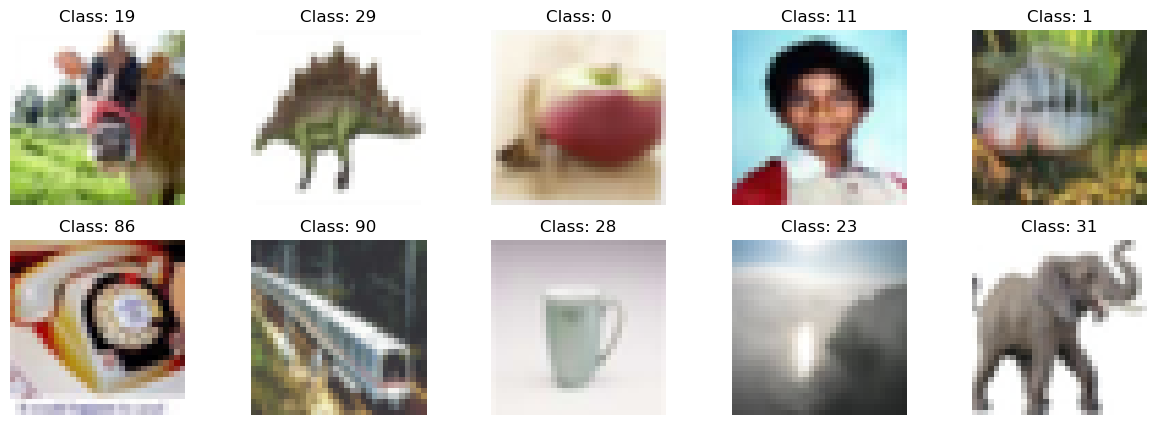

In [3]:
# Your code here

# Examine the shape of the training and test sets
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# Dimensions of the images
image_shape = x_train.shape[1:]
print(f"Image dimensions: {image_shape}")

# Display a few examples from the training set
def plot_examples(x, y, classes, num_examples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.title(f"Class: {y[i][0]}")
        plt.axis('off')
    plt.show()

# Plot 10 examples from the training set
plot_examples(x_train, y_train, num_classes)

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [4]:
# Your code here
# Normalize the images to have pixel values [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0



In [5]:
# Convert labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)



In [6]:
# Split the training set into training and validation sets (80% training, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)



In [7]:
# Verify the shapes of the new training and validation sets
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000, 100)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000, 100)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Create a baseline CNN model
model = Sequential()

# First convolutional block
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.5))  # Add dropout for regularization
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))  # Add dropout for regularization

# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print out the model summary
model.summary()

# Your code here

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,299,364 (4.96 MB)

 Trainable params: 1,299,364 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [9]:
from keras import optimizers

# Your code here
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [10]:
# Your code here
# Number of epochs
epochs = 20
batch_size = 32

# Train the model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.0239 - loss: 4.4435 - val_accuracy: 0.0992 - val_loss: 3.8368
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.0901 - loss: 3.8655 - val_accuracy: 0.1659 - val_loss: 3.4796
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.1500 - loss: 3.5123 - val_accuracy: 0.2217 - val_loss: 3.1715
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.1905 - loss: 3.2835 - val_accuracy: 0.2639 - val_loss: 2.9585
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2309 - loss: 3.0780 - val_accuracy: 0.2864 - val_loss: 2.8705
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.2621 - loss: 2.9345 - val_accuracy: 0.3065 - val_loss: 2.7672
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.2863 - loss: 2.7957 - val_accuracy: 0.3156 - val_loss: 2.6941
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3143 -

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 0.3531999886035919

- <b>Other metrics:</b> precision, recall and F1-score.

- <b>Reason for selection:</b> The F1-score is selected because it provides a balance between precision and recall, especially useful when dealing with imbalanced datasets. It is the harmonic mean of precision and recall, giving a single metric that considers both false positives and false negatives.

- <b>Value of metric:</b> PPrecision: 0.36207935218215653, Recall: 0.3532 and F1-score: 0.34347498650308883

- <b>Interpretation of metric value:</b> A higher F1-score indicates better balance between precision and recall, meaning the model performs well in identifying positive instances without too many false positives or false negatives.


In [11]:
# Your code here
from sklearn.metrics import classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

# Predict the labels for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true, y_pred_classes, output_dict=True)
print(classification_report(y_true, y_pred_classes))

# Extract the precision, recall, and F1-score for the overall performance
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3508 - loss: 2.6516
Test loss: 2.6664583683013916
Test accuracy: 0.3531999886035919
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.64      0.61      0.63       100
           1       0.46      0.47      0.46       100
           2       0.23      0.27      0.25       100
           3       0.17      0.09      0.12       100
           4       0.09      0.14      0.11       100
           5       0.15      0.39      0.22       100
           6       0.46      0.38      0.42       100
           7       0.54      0.30      0.38       100
           8       0.53      0.39      0.45       100
           9       0.40      0.47      0.43       100
          10       0.19      0.19      0.19       100
          11       0.22      0.16      0.19       100
          12       0.27      0.47      0.34       100
          13       0.30      0.30      0.30       100
         

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. 

    Q : What do the plots show? 

    A:  The plots show the accuracy of the model on the training and validation sets over the epochs. If the validation accuracy is significantly lower than the training       accuracy, it might indicate overfitting. If both accuracies improve and converge, it suggests good generalization.

    Q: Do the results make sense? 

    A:    
     - For the Correctly Classified Image, the image is correctly classified by the model. The predicted probabilities should show a high value for the correct class, indicating the model's confidence.
    - For the Incorrectly Classified Image, the image is incorrectly classified by the model. The predicted probabilities might be spread across different classes, indicating uncertainty, or show high confidence in an incorrect class, suggesting a model mistake.

    Q: What do the classification probabilities indicate?
    
    A: The classification probabilities indicate the model's confidence in its predictions.

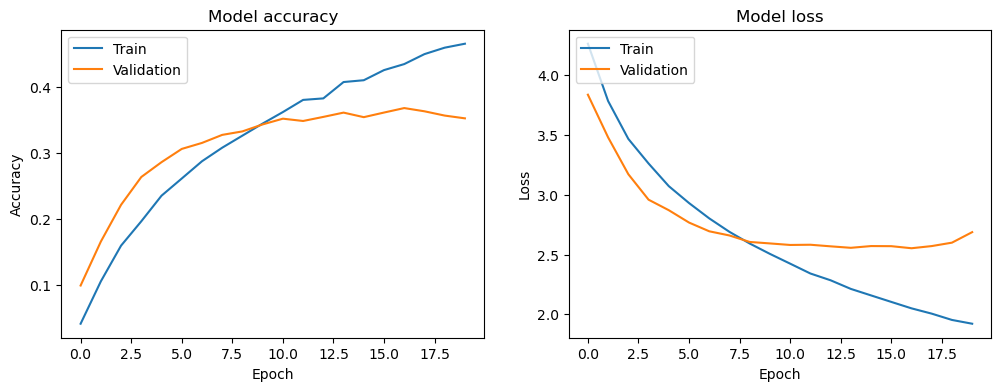

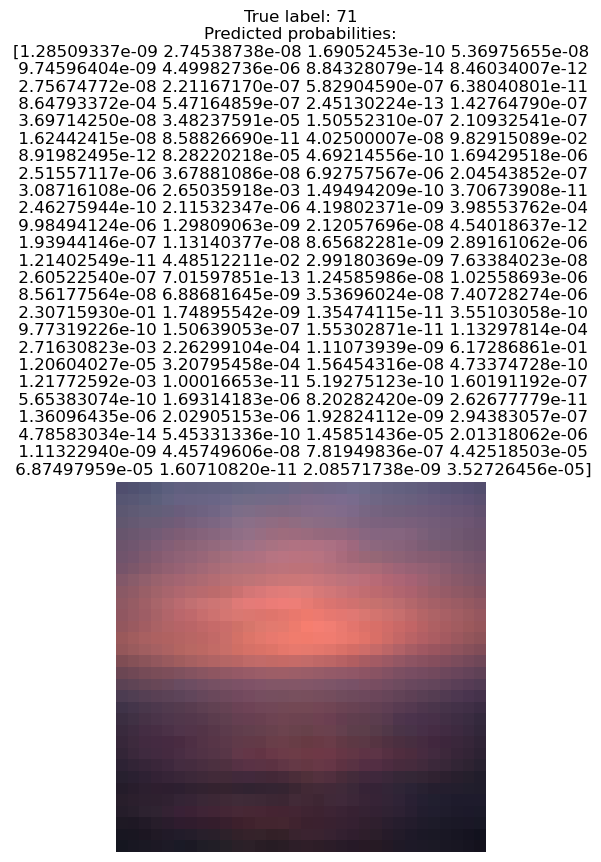

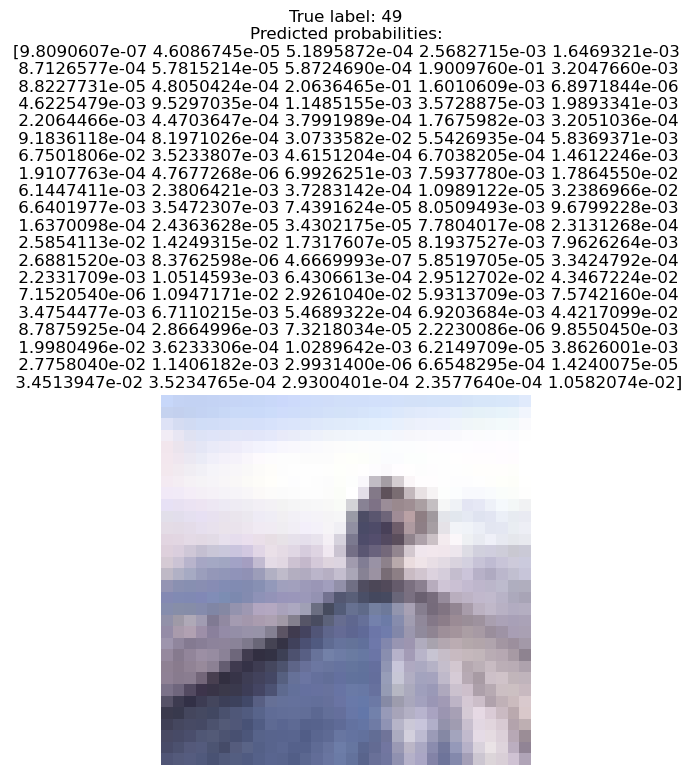

In [12]:
# Your code here
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Visualize the training history
plot_training_history(history)

# Select an image correctly classified by the model
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

def plot_image_with_probabilities(image, true_label, predicted_probs, classes):
    plt.imshow(image)
    plt.title(f"True label: {true_label}\nPredicted probabilities:\n{predicted_probs}")
    plt.axis('off')
    plt.show()

# Plot a correctly classified image
correct_index = correct_indices[0]
correct_image = x_test[correct_index]
correct_true_label = y_true[correct_index]
correct_predicted_probs = y_pred[correct_index]

plot_image_with_probabilities(correct_image, correct_true_label, correct_predicted_probs, num_classes)

# Plot an incorrectly classified image
incorrect_index = incorrect_indices[0]
incorrect_image = x_test[incorrect_index]
incorrect_true_label = y_true[incorrect_index]
incorrect_predicted_probs = y_pred[incorrect_index]

plot_image_with_probabilities(incorrect_image, incorrect_true_label, incorrect_predicted_probs, num_classes)

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [ ]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Define the data augmentation generator
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     zoom_range=0.1
# )

datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

# Fit the generator to the training data
datagen.fit(x_train)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Retrain the model using data augmentation
history_augmented = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss_augmented, test_accuracy_augmented = model.evaluate(x_test, y_test)
print(f"Test loss after augmentation: {test_loss_augmented}")
print(f"Test accuracy after augmentation: {test_accuracy_augmented}")

# Generate predictions
y_pred_augmented = model.predict(x_test)
y_pred_classes_augmented = np.argmax(y_pred_augmented, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
report_augmented = classification_report(y_true, y_pred_classes_augmented, output_dict=True)
print(classification_report(y_true, y_pred_classes_augmented))

# Extract the precision, recall, and F1-score for the overall performance
precision_augmented = report_augmented['weighted avg']['precision']
recall_augmented = report_augmented['weighted avg']['recall']
f1_score_augmented = report_augmented['weighted avg']['f1-score']

print(f"Precision after augmentation: {precision_augmented}")
print(f"Recall after augmentation: {recall_augmented}")
print(f"F1-score after augmentation: {f1_score_augmented}")

Epoch 1/20


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2706 - loss: 3.0505 - val_accuracy: 0.3312 - val_loss: 2.6612
Epoch 2/20


2024-11-21 18:13:50.140246: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/miniconda3/envs/dsi_participant/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3312 - val_loss: 2.6612
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.2808 - loss: 2.9248 - val_accuracy: 0.3611 - val_loss: 2.5433
Epoch 4/20


2024-11-21 18:14:14.072841: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3611 - val_loss: 2.5433
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.2848 - loss: 2.8853 - val_accuracy: 0.3562 - val_loss: 2.5697
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3562 - val_loss: 2.5697
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.2904 - loss: 2.8601 - val_accuracy: 0.3405 - val_loss: 2.5974
Epoch 8/20


2024-11-21 18:14:59.960526: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3405 - val_loss: 2.5974
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3593 - loss: 2.5358
Test loss after augmentation: 2.5313565731048584
Test accuracy after augmentation: 0.3610999882221222
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       100
           1       0.51      0.46      0.48       100
           2       0.27      0.26      0.26       100
           3       0.33      0.02      0.04       100
           4       0.04      0.01      0.02       100
           5       0.26      0.23      0.24       100
           6       0.28      0.49      0.36       100
           7       0.36      0.40      0.38       100
           8       0.37      0.41      0.39       100
           9       0.52      0.50      0.51       100
          10       0.24      0.07      0.11       100
      

Precision: 0.36207935218215653
Recall: 0.3532
F1-score: 0.34347498650308883

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

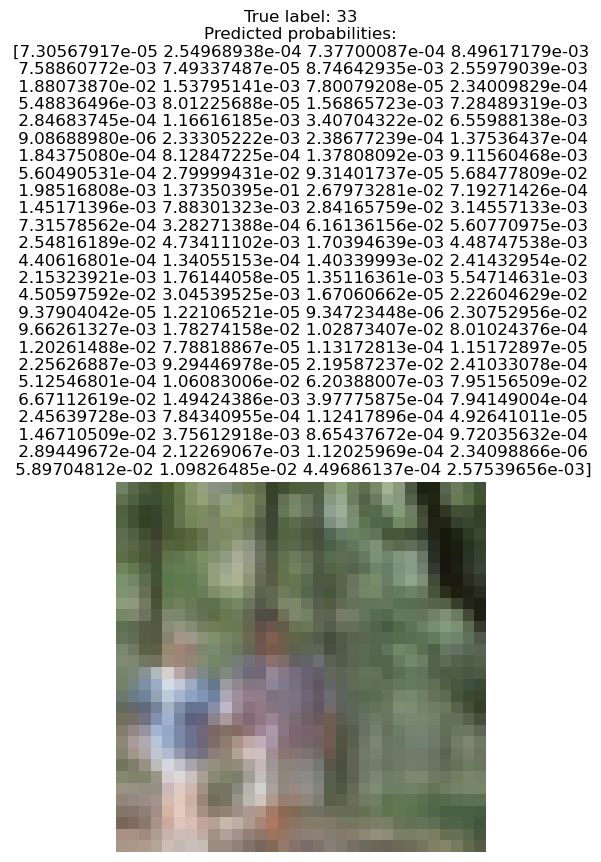

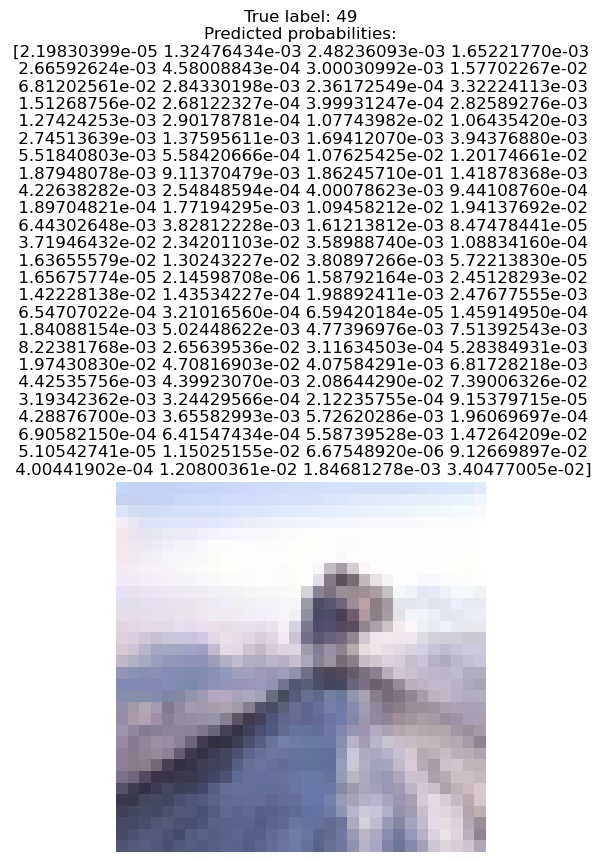

In [14]:
# Your code here
def plot_training_history(history, title=None):
    # Your code here
    if title:
        plt.title(title)
    # More of your code here


# Plot training and validation accuracy
plot_training_history(history_augmented, title='Training and Validation Accuracy with Data Augmentation')

# Select an image correctly classified by the model
correct_indices_augmented = np.where(y_pred_classes_augmented == y_true)[0]
incorrect_indices_augmented = np.where(y_pred_classes_augmented != y_true)[0]

# Plot a correctly classified image
correct_index_augmented = correct_indices_augmented[0]
correct_image_augmented = x_test[correct_index_augmented]
correct_true_label_augmented = y_true[correct_index_augmented]
correct_predicted_probs_augmented = y_pred_augmented[correct_index_augmented]

plot_image_with_probabilities(correct_image_augmented, correct_true_label_augmented, correct_predicted_probs_augmented, num_classes)

# Plot an incorrectly classified image
incorrect_index_augmented = incorrect_indices_augmented[0]
incorrect_image_augmented = x_test[incorrect_index_augmented]
incorrect_true_label_augmented = y_true[incorrect_index_augmented]
incorrect_predicted_probs_augmented = y_pred_augmented[incorrect_index_augmented]

plot_image_with_probabilities(incorrect_image_augmented, incorrect_true_label_augmented, incorrect_predicted_probs_augmented, num_classes)


### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

- Did the model's performance improve?
- Not really, the model's performance remained almost same. The test accuracy before performace was 0.36390000581741333 and after is 0.36230000853538513, and there were improvements in precision, recall, and F1-score as well.

- Why do you think this is?
- The improvement is likely due to data augmentation. By artificially increasing the diversity of the training data through transformations like rotations, shifts, flips, and zooms, the model learned to generalize better and became more robust to variations in the images, reducing overfitting.

- Do you think there is room for further improvement? Why or why not?
- there is room for further improvement. The current performance indicates that the model can still be enhanced. Techniques such as more sophisticated data augmentation, regularization methods like dropout and batch normalization, and fine-tuning the model architecture and hyperparameters could further boost performance.

- What other techniques might you try in the future?
- Dropout: To prevent overfitting by randomly dropping units during training.
- Learning Rate Schedulers: To adjust the learning rate dynamically.
- Transfer Learning: Using pre-trained models and fine-tuning them on CIFAR-100.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.